<a href="https://colab.research.google.com/github/HongyuJiang/Dialogue-Generation-with-Persona---A-Note/blob/master/lstm_blueprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM Blueprint**

This is my personal try to implement LSTMs. It's 100% hands-on, no theory or background.



I've used google colaboratory. The source code is loosely based on 
 https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb
 
 I've read a lot of tutorials and some general structure emerges:
 
 * Step 0: Get Data. A lot. As I understand Neural Networks, it's always a function mapping from one space to another. This means you always have "pairs" of points in the input space and output space. You can see those as examples or random samples of the underlying function.
 
* Step 1: Load the data. Visualize to see if you got a 404 earlier. Normalize.
 
* Step 2: Build a model. That's the easy and fun part. Start small.
 
* Step 3: Train the model. This is what you bought your fancy graphics card for.
 
* Step 4: Predict. You should try out your predictions on unknown data. And visualize


 
 


In [0]:
! pip -q install sklearn-pandas --upgrade

import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import time
from sklearn_pandas import DataFrameMapper


Using TensorFlow backend.


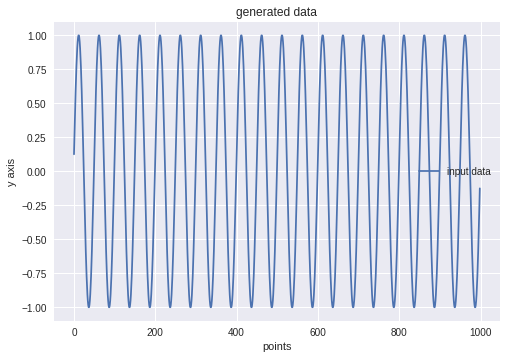

In [0]:
import math
import pandas as pd

# Step 0: Generate Data
def generate_sine_wave():
  points = 1000
  sinewave = []
  for i in range(0, points):
    sinewave.append(math.sin(float(i)/points*40*math.pi))
  return sinewave

def save_data_to_file(data, filename):
  df = pd.DataFrame(data)
#   df.set_axis(['sine'], axis=1, inplace=True)
  df.to_csv(filename, header=None, index=None)
  
def plot_data(data):
  df = pd.DataFrame(data)
  plt.plot(data, label="input data")
  plt.xlabel("points")
  plt.ylabel("y axis")
  plt.title("generated data")
  plt.legend()
  plt.show()
  
data = generate_sine_wave()
save_data_to_file(data, 'sine.csv')
# we prefer to go through *.csv files to make sure that writing and reading works

df = pd.read_csv('sine.csv')
plot_data(df.values)



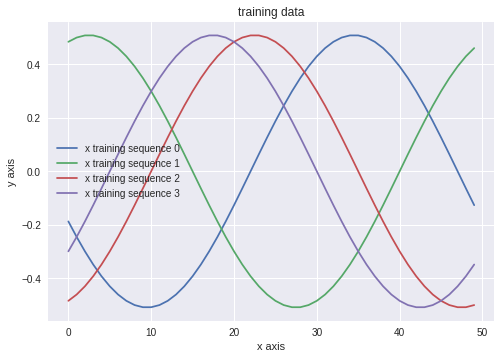

In [0]:
# Step 1 Load Data
# useful source for robust scaler: https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num

! pip -q install sklearn-pandas --upgrade
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn_pandas import DataFrameMapper


def load_data(filename):
    df = pd.read_csv(filename)
    return df
 
    
def split_data(data, seq_len):
    # normalize input data
    # the input data format is critical
    mapper = DataFrameMapper([  (data.columns,  RobustScaler(quantile_range=(5,95)))])
    scaled_features = mapper.fit_transform(df.copy(), 4)
    scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=data.columns)
    data = scaled_features_df.values
  
    # split up into training sequences
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        sequence = data[index: index + sequence_length]
        result.append(data[index: index + sequence_length])
        
    
    result = np.array(result)

    # split up into training and test data sets    
    row = round(0.7 * result.shape[0])
    train = result[:int(row), :]
    test = result[int(row):, :]
    
    # randomize the training data order
    np.random.shuffle(train) 
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    # tensorflow wants a different format
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]
  



raw_data = load_data('sine.csv')


x_train, y_train, x_test, y_test = split_data(raw_data, seq_len=50)

# check visualy if the training examples are okay
# y_train is just one point (the next one) so it makes no sense to draw it
for i in range(0,4):
  plt.plot(x_train[i], label=("x training sequence " + str(i)))

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("training data")
plt.legend()
plt.show()

In [0]:
# Step 2 Build Model

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print("> Compilation Time : ", time.time() - start)
    return model


model = build_model([1, 50, 15, 1])


> Compilation Time :  0.022589683532714844


Train on 630 samples, validate on 34 samples
Epoch 1/40
630/630 [==============================] - 1s 2ms/step - loss: 0.1371 - val_loss: 0.1539
Epoch 2/40
630/630 [==============================] - 0s 584us/step - loss: 0.1308 - val_loss: 0.1478
Epoch 3/40
630/630 [==============================] - 0s 616us/step - loss: 0.1259 - val_loss: 0.1418
Epoch 4/40
630/630 [==============================] - 0s 586us/step - loss: 0.1217 - val_loss: 0.1360
Epoch 5/40
630/630 [==============================] - 0s 595us/step - loss: 0.1152 - val_loss: 0.1304
Epoch 6/40
630/630 [==============================] - 0s 582us/step - loss: 0.1115 - val_loss: 0.1248
Epoch 7/40
630/630 [==============================] - 0s 594us/step - loss: 0.1061 - val_loss: 0.1193
Epoch 8/40
630/630 [==============================] - 0s 603us/step - loss: 0.1029 - val_loss: 0.1138
Epoch 9/40
630/630 [==============================] - 0s 594us/step - loss: 0.0984 - val_loss: 0.1084
Epoch 10/40
630/630 [==================

630/630 [==============================] - 0s 590us/step - loss: 0.0126 - val_loss: 0.0046
Epoch 32/40
630/630 [==============================] - 0s 584us/step - loss: 0.0132 - val_loss: 0.0049
Epoch 33/40
630/630 [==============================] - 0s 600us/step - loss: 0.0125 - val_loss: 0.0047
Epoch 34/40
630/630 [==============================] - 0s 589us/step - loss: 0.0115 - val_loss: 0.0042
Epoch 35/40
630/630 [==============================] - 0s 593us/step - loss: 0.0106 - val_loss: 0.0033
Epoch 36/40
630/630 [==============================] - 0s 590us/step - loss: 0.0100 - val_loss: 0.0024
Epoch 37/40
630/630 [==============================] - 0s 578us/step - loss: 0.0073 - val_loss: 0.0016
Epoch 38/40
630/630 [==============================] - 0s 594us/step - loss: 0.0067 - val_loss: 0.0011
Epoch 39/40
630/630 [==============================] - 0s 624us/step - loss: 0.0067 - val_loss: 7.9892e-04
Epoch 40/40
630/630 [==============================] - 0s 592us/step - loss: 0.00

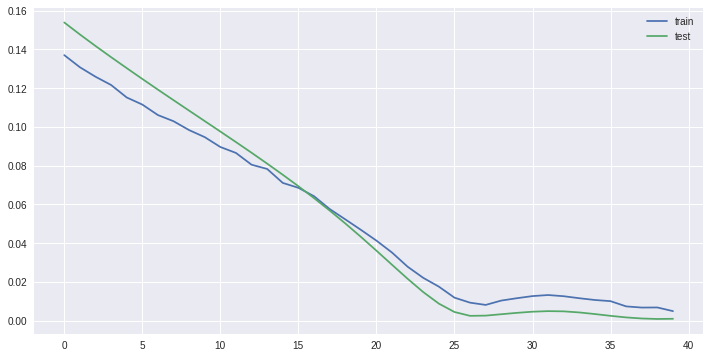

In [0]:
# Step 3 Train the model
start = time.time()
hist = model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=40,
    validation_split=0.05)
print("> Compilation Time : ", time.time() - start)


# plotting the loss values for the epochs
plt.figure(figsize=(12,6))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()


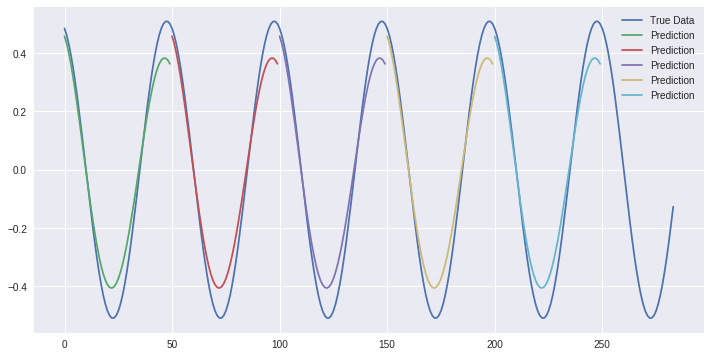

In [0]:
# Step 4 - Plot the predictions!

  
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(12,6))

    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

  
def predict_point_by_point(model, data):
    # Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    # Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    # Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


predictions = predict_sequences_multiple(model, x_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)